<a href="https://colab.research.google.com/github/calerovillalobos10/Intro_Limpieza_Transf_Data/blob/main/Lab2_PF3347.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 Limpieza y Transformación de Datos

## Estudiantes

*   Bryan Thomas Calero Villalobos
*   Daniela Montero Parkinson
*   Christopher Zúñiga Cárdenas

# Uso práctico

## Extracción de datos

Se ingresa a la página de [OpenQA](https://openaq.org/) para consumir el API que nos da la documentación, en este caso se utilizará para el trabajo el API V3. En la documentación del api se indica registrarse en [Registro](https://explore.openaq.org/register) e ir al apartado de *cuenta*, con el fin de capturar el API KEY necesario para consumir el API.

Como primer paso se instalan las librerías necesarias para poder consumir el API mencionado y capturar las variables de entorno

In [203]:
# Instalar las librerías necesarias
!pip3 install requests
!pip3 install python-dotenv

Se importan las librerías para poder utilizarlas en los métodos definidos

In [204]:
import requests
import os
from dotenv import load_dotenv
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from urllib.parse import urlencode
from datetime import datetime

Se descargar el archivo del .env que se encuentra en drive

In [205]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1JrTQmCwUWuru9BJFCwuG25_aIT1uN4XR' -O .env

--2024-09-22 01:49:38--  https://drive.google.com/uc?export=download&id=1JrTQmCwUWuru9BJFCwuG25_aIT1uN4XR
Resolving drive.google.com (drive.google.com)... 173.194.217.101, 173.194.217.138, 173.194.217.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.217.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1JrTQmCwUWuru9BJFCwuG25_aIT1uN4XR&export=download [following]
--2024-09-22 01:49:38--  https://drive.usercontent.google.com/download?id=1JrTQmCwUWuru9BJFCwuG25_aIT1uN4XR&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.204.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79 [application/octet-stream]
Saving to: ‘.env’

.env                100%[===================>]      79  --.-KB/s    in 0s      


Obtener el api key para consumir la información del sitio Open AQ

In [206]:
load_dotenv('.env') # Cargar el archivo .env descargado
API_KEY = os.getenv('KEY_OpenAQ') # Obtener el API KEY de la variable de entorno

Se inicializa una variable con la url a consumir

In [207]:
api_url = f'https://api.openaq.org/v2/measurements'

Se definen los parámetros que se enviarán al enpoint y mediante este método se construye la url final a consumir

In [208]:
# Construye la URL con los parámetros necesarios
def build_url(country, start_date, end_date, page, limit):
  # Parámetros para la solicitud: país, fechas y página actual
  params = {
    'date_from': start_date,
    'date_to': end_date,
    'limit': limit,  # Ajusta el límite según lo necesario
    'page': page,
    'country': country,
    'sort': 'desc',
    'order_by': 'datetime'
  }

  return f"{api_url}?{urlencode(params)}"

Este método se implementó para solucionar el problema Request Time-out que arroja el api, dado a la cantidad de información que trae. Se funcionalidad es crear una sesión HTTP que aplica reintentos automáticos cuando se producen errores temporales o de conexión en solicitudes GET

In [209]:
# Método para crear la estrategia de reintentos
def create_retry_session(max_retries):
    retry_strategy = Retry(
        total=max_retries,  # Número máximo de reintentos
        status_forcelist=[408, 500, 502, 503, 504],  # Errores a los que se aplicarán los reintentos
        allowed_methods=["GET"],  # Solo reintentar en solicitudes GET
        backoff_factor=1  # Tiempo de espera entre reintentos
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)

    # Crear una sesión de requests con el adaptador de reintentos
    http = requests.Session()
    http.mount("https://", adapter)

    return http  # Devolver la sesión con la estrategia de reintentos

El siguiente método consume el API utilizando requests, obteniendo los datos de los países que proporciona la web. Este retorna una lista de diccionarios sobre los países con el método .json() utilizado en la línea data = response.json()

In [210]:
# Obtiene los datos de cada país
def fetch_country_data(country, start_date, end_date, limit, max_retries=1):
  all_data = [] # Lista para almacenar los datos obtenidos de todas las páginas

  try:

    page = 1  # Se inicia en la primera página
    has_more_data = True  # Control para el bucle
    headers = {"accept": "application/json", "X-API-Key": API_KEY} # Encabezados de la solicitud, incluyendo la API Key

    # Usar el nuevo método para crear la sesión con reintentos
    http = create_retry_session(max_retries)

    # Bucle para hacer solicitudes mientras haya más datos disponibles
    while has_more_data:
      # Crear la URL con los parámetros del país, fechas, página y límite
      url = build_url(country, start_date, end_date, page, limit)

      response = http.get(url, headers=headers) # Realiza la solicitud HTTP al API
      response.raise_for_status() # Lanza un error si la respuesta no es exitosa

      data = response.json().get('results', [])
      all_data.extend(data)  # Añade los datos de la página actual a la lista general

      if len(data) < limit:
        print(f"{country} No más datos")
        has_more_data = False # Si no hay más datos, se finaliza el bucle
      else:
        page += 1  # Si hay más datos, avanzar a la siguiente página

  except requests.RequestException as e:
    print(f"{country} No más datos")

  return all_data

La siguiente función obtiene datos de varios países en un rango de fechas específico y con un límite de resultados por país. Recorre una lista de países, llama a la función fetch_country_data para cada uno, y si se obtienen datos, los almacena en una lista que finalmente retorna.

In [211]:
# Función para obtener los datos de varios países
def get_countries_data(countries, start_date, end_date, limit):

  all_data = [] # Lista para almacenar todos los datos obtenidos

  # Ciclo sobre la lista de países
  for country in countries:

    print(f"Obteniendo datos para {country}...")
    # Llamada a una función que obtiene los datos del país en un periodo específico
    data = fetch_country_data(country, start_date, end_date, limit)

    if any(data):
      all_data.extend(data) # si existen datos se añaden los resultados a la lista general

  return all_data

Parámetros para definir los datos que se quieren obtener del api de open qa

In [212]:
# Parámetros para el enpoint
countries = ['CR', 'BE', 'DE', 'PE', 'AR', 'US']  # Costa Rica, Belgica, Alemania , Peru, Argentina, Estados Unidos

start_date = '2014-01-01T00:00:00Z'
end_date = datetime.utcnow().isoformat() + "Z"

data = get_countries_data(countries, start_date, end_date, 15000)

Obteniendo datos para CR...
CR No más datos
Obteniendo datos para BE...
BE No más datos
Obteniendo datos para DE...
DE No más datos
Obteniendo datos para PE...
PE No más datos
Obteniendo datos para AR...
AR No más datos
Obteniendo datos para US...
US No más datos


## Análisis EDA Exploratorio

### Descripción del conjunto de datos
El conjunto de datos recuperados desde el API contiene casi 500,000  filas y 15 columnas. En esta información recuperada se identificó algunos parámetros de interés:
* locationId: y location los cuales son parámetros que funcionan para identificar ubicaciones.
* parameter: el cuál es un indicador para los tipos de parámetros medidos (como pm25, que es un contaminante).
* value: el cual es el parámetro que trae valores de las mediciones.
* unit: Son las unidades de medición (microgramos por metro cúbico, µg/m³).
* coordinates.latitude y coordinates.longitude: los cuales son parámetros para la ubicación geográfica de las mediciones.




### Columnas con valores nulos o problemáticos
* city,  isAnalysis y isMobile: son columnas que vienen completamente vacías, dado a los países que se seleccionaron para la revisión. Estas columnas podrían eliminarse si no son útiles.
* sensorType y entity: en todas las filas vienen con un mismo.
* value: tiene valores problemáticos como -999.0, lo cual probablemente represente datos faltantes. Estos deben corregirse o imputarse adecuadamente.



### Detección de valores atípicos en las mediciones
Dentro de la columna value se detectaron valores atípicos (outliers) lo cual indica la presencia de valores “extremos” lo que podría afectar en el análisis de los datos.



### Análisis de los parámetros medidos (parameter)
Se debe analizar la distribución de los diferentes parámetros medidos, como PM25, NO2, CO, entre otros. Con el fin de entender mejor qué contaminantes se monitorean con mayor frecuencia.


#### Preguntas clave:
* ¿Qué parámetros de calidad del aire son los más comunes en el conjunto de datos?
* ¿Cómo varían los valores de estos parámetros en diferentes ubicaciones?

## Limpieza de datos y Transformación

Se importan librerías necesarias y se asigna la data a otra variable para manipular sin tocar los datos originales

In [362]:
import pandas as pd
from pandas import json_normalize

# Normalizar los datos
df_results = data

Se inicia la exploración de datos para empezar a limpiar data

In [363]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Se transforman los datos a un DataFrame para una mejora manipulación de los datos

In [364]:
datos = pd.DataFrame(df_results)

Se hace un .head para empezar a familiarizar con los datos

In [365]:
print(f'Descripcion Data: ')
datos.head() #muestra de los primeros 5 registros

Descripcion Data: 


,locationId,location,parameter,value,date,unit,coordinates,country,city,isMobile,isAnalysis,entity,sensorType
0,7077,US Diplomatic Post: San Jose,pm25,-999.0,"{'utc': '2024-09-22T01:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 9.949488, 'longitude': -84.142876}",CR,None,False,None,Governmental Organization,reference grade
1,7077,US Diplomatic Post: San Jose,pm25,-999.0,"{'utc': '2024-09-22T00:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 9.949488, 'longitude': -84.142876}",CR,None,False,None,Governmental Organization,reference grade
2,7077,US Diplomatic Post: San Jose,pm25,-999.0,"{'utc': '2024-09-21T23:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 9.949488, 'longitude': -84.142876}",CR,None,False,None,Governmental Organization,reference grade
3,7077,US Diplomatic Post: San Jose,pm25,-999.0,"{'utc': '2024-09-21T22:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 9.949488, 'longitude': -84.142876}",CR,None,False,None,Governmental Organization,reference grade
4,7077,US Diplomatic Post: San Jose,pm25,-999.0,"{'utc': '2024-09-21T21:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 9.949488, 'longitude': -84.142876}",CR,None,False,None,Governmental Organization,reference grade


Como se detectaron datos anidados (dict) se realiza la siguiente normalización y condición para separa los datos en nuevas columnas

In [366]:
# Normalizar los datos
datos_normalizados = json_normalize(df_results)

# Si hay parámetros anidados dentro de los resultados, normalizarlos también
if 'parameters' in datos_normalizados.columns:
  df_parameters = json_normalize(datos_normalizados['parameters'].explode())
  datos_normalizados = datos_normalizados.drop(columns=['parameters']).join(df_parameters, rsuffix='_param')

Se vuelve a imprimir el dataframe para visualizar las nuevas columas

In [367]:
datos = pd.DataFrame(datos_normalizados)
datos.head()

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
0,7077,US Diplomatic Post: San Jose,pm25,-999.0,µg/m³,CR,None,False,None,Governmental Organization,reference grade,2024-09-22T01:00:00+00:00,2024-09-21T19:00:00-06:00,9.949488,-84.142876
1,7077,US Diplomatic Post: San Jose,pm25,-999.0,µg/m³,CR,None,False,None,Governmental Organization,reference grade,2024-09-22T00:00:00+00:00,2024-09-21T18:00:00-06:00,9.949488,-84.142876
2,7077,US Diplomatic Post: San Jose,pm25,-999.0,µg/m³,CR,None,False,None,Governmental Organization,reference grade,2024-09-21T23:00:00+00:00,2024-09-21T17:00:00-06:00,9.949488,-84.142876
3,7077,US Diplomatic Post: San Jose,pm25,-999.0,µg/m³,CR,None,False,None,Governmental Organization,reference grade,2024-09-21T22:00:00+00:00,2024-09-21T16:00:00-06:00,9.949488,-84.142876
4,7077,US Diplomatic Post: San Jose,pm25,-999.0,µg/m³,CR,None,False,None,Governmental Organization,reference grade,2024-09-21T21:00:00+00:00,2024-09-21T15:00:00-06:00,9.949488,-84.142876


Esta línea de código devuelve el análisis de la tabla para exploración

In [368]:
# inicio de analisis y limpieza
print(f'Descripción Data: ')# devuelve el analisis de la tabla para exploracion el mismo devuelve: promedio, conteo, min, max , persentiles 25/50/75 y desviacion estandar por cada variable
datos.describe()

Descripción Data: 


,locationId,value,coordinates.latitude,coordinates.longitude
count,396487.000000,396487.000000,396487.000000,396487.000000
mean,3035.288289,-15.206889,24.193491,-41.043062
std,2168.955504,178.789571,30.829492,44.957370
min,161.000000,-999.000000,-34.625270,-95.756601
25%,819.000000,0.034000,9.949488,-84.142876
50%,2948.000000,5.300000,29.723300,-58.365550
75%,4809.000000,18.000000,49.719281,5.630398
max,7077.000000,1380.000000,53.559784,14.525960


La siguiente línea de código nos dice el tipo de dato por columna y cantidad de nulos

In [369]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396487 entries, 0 to 396486
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   locationId             396487 non-null  int64  
 1   location               396487 non-null  object 
 2   parameter              396487 non-null  object 
 3   value                  396487 non-null  float64
 4   unit                   396487 non-null  object 
 5   country                396487 non-null  object 
 6   city                   0 non-null       object 
 7   isMobile               396487 non-null  bool   
 8   isAnalysis             0 non-null       object 
 9   entity                 396487 non-null  object 
 10  sensorType             396487 non-null  object 
 11  date.utc               396487 non-null  object 
 12  date.local             396487 non-null  object 
 13  coordinates.latitude   396487 non-null  float64
 14  coordinates.longitude  396487 non-nu

la siguiente línea ayuda para visualizar datos en null

In [370]:
datos.isnull()

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
0,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396482,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
396483,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
396484,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
396485,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False


La siguiente línea devuelve la cantidad de nulos

In [395]:
datos.isnull().sum()

,0
locationId,0
location,0
parameter,0
value,0
unit,0
country,0
date.utc,0
date.local,0
coordinates.latitude,0
coordinates.longitude,0


Esta porción de código lo que permite es identificar cuáles columnas se mantendrán para el análisis de los datos. Al ejecutar esta lógica se identifica que hay columnas con 0 subniveles, lo cual quiere decir que se pueden eliminar debido a que contienen solo datos nulos, y las que tienen solo 1 nivel constan de solo un mismo dato (repetido a lo largo de las filas) por lo que, para el análisis, no se hacen relevantes este tipo de columnas

In [372]:
#inicio deteccion de niveles
cols_cat = datos.columns.tolist() # se capturan los nombres de las columnas del DF

# se inicializa un array para capturar las columnas que se descartarán por poca relevancia
col_descartadas = []

#Con este fragmento de codigo nos damos cuanta cuantos subniveles tiene cada columna, esto nos ayuda a ver cuales son las variables finales para la data
for col in cols_cat:
  print(f'Columna {col}: {datos[col].nunique()} subniveles')

  if(datos[col].nunique() <= 1):
    col_descartadas.append(col)

Columna locationId: 48 subniveles
Columna location: 48 subniveles
Columna parameter: 6 subniveles
Columna value: 23002 subniveles
Columna unit: 2 subniveles
Columna country: 6 subniveles
Columna city: 0 subniveles
Columna isMobile: 1 subniveles
Columna isAnalysis: 0 subniveles
Columna entity: 1 subniveles
Columna sensorType: 1 subniveles
Columna date.utc: 70417 subniveles
Columna date.local: 148812 subniveles
Columna coordinates.latitude: 48 subniveles
Columna coordinates.longitude: 48 subniveles


Al haber detectado las columnas menos relevantes o que no serán útiles se eliminan para optimizar o reducir la carga de procesamiento al realizar el respectivo análisis o sus visualizaciones

In [373]:
# luego de notar que las columnas city, isMobile, isAnalysis, entity, sensorType tienen 1 o 0 subniveles y se deciden eliminar de la data
datos.drop(columns=col_descartadas, inplace=True) # Con inplace=True: modifica datos directamente, sin crea un dataframe nuevo

La siguiente celda se utiliza para detectar cuántos duplicados hay en los datos y eliminarlos si se encuentran

In [374]:
# Inicio duplicados
duplicados = datos.duplicated().sum() #contar datos duplicados

#Elimina los duplicados si es que los hay
if duplicados > 1:
  print(f'Tamaño previo: {datos.shape}')
  datos.drop_duplicates(inplace=True)
  print(f'Tamaño posterior: {datos.shape}')
else:
  print('No hay filas duplicadas')

No hay filas duplicadas


Se eliminan los espacios para mantener un estandar y buenas prácticas de limpieza, ya que hay datos que pueden tener espacios que evitan el poder realizar un cruce de datos

In [375]:
# Eliminar espacios al principio y al final en todas las columnas de texto
datos['location'] = datos['location'].str.strip()
datos['parameter'] = datos['parameter'].str.strip()
datos['unit'] = datos['unit'].str.strip()
datos['country'] = datos['country'].str.strip()

En esta porción de código se visualizan los datos y se detecta que solo la variable *value* tiene datos muy bajos o muy altos (atípicos). El más repetido es el -999, el cual se entiende como un valor atípico

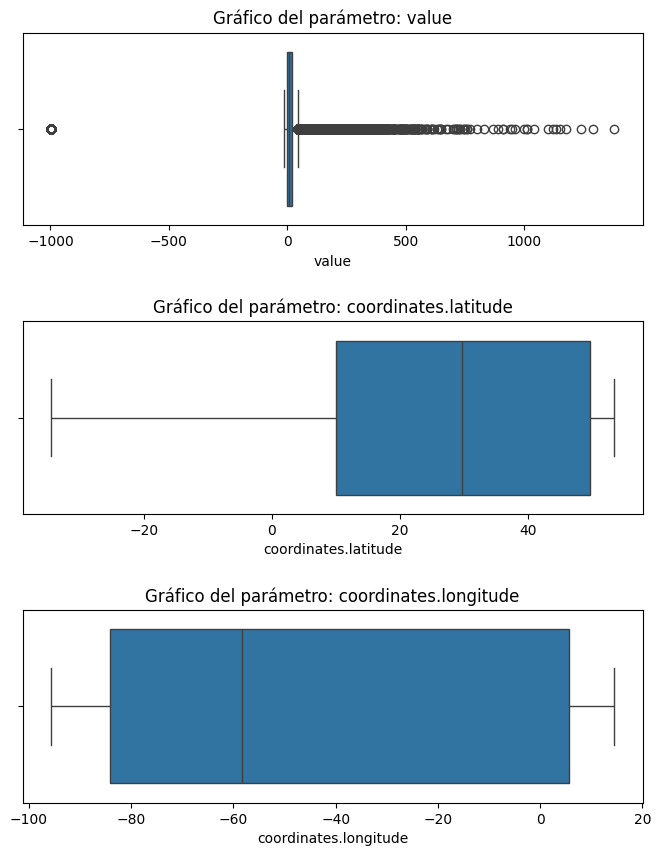

In [376]:
#revision de outliers en variables numericas
cols_num = ['value', 'coordinates.latitude', 'coordinates.longitude']

# Define la estructura del gráfico
fig, ax = plt.subplots(nrows = len(cols_num), ncols = 1, figsize = (8,10))
fig.subplots_adjust(hspace = 0.5) # Espacio entre gráficos

for i, col in enumerate(cols_num):
    sns.boxplot(x = col, data = datos, ax = ax[i]) # información para crear el gráfico
    ax[i].set_title(f'Gráfico del parámetro: {col}') # Nombre del gráfico

plt.show() # Muestra el gráfico

Se realiza limpieza de outliers utilizando zscale

In [377]:
maximo_valor = datos.value.max()
ultimo_valor = datos.value.min()
print(f'Datos menor: {ultimo_valor}')
print(f'Datos mayor: {maximo_valor}')

Datos menor: -999.0
Datos mayor: 1380.0


Revisamos la cantidad de registros el dataframe antes de aplicar la función de limipeza del zscore

In [378]:
num_filas = datos.shape[0]
print(f'Cantidad de filas: {num_filas}')

Cantidad de filas: 396487


Se utiliza el método quantile para eliminar los outliners

In [380]:
##########
# Calcular los cuartiles
Q1 = datos['value'].quantile(0.25)
Q3 = datos['value'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar los outliers
datos = datos[(datos['value'] >= limite_inferior) & (datos['value'] <= limite_superior)]
###############

Se revisa la cantidad de registros después de aplicado el zscore

In [381]:
num_filas = datos.shape[0]
print(f'Cantidad de filas: {num_filas}')

Cantidad de filas: 346463


Se limpian las variables con tipos de datos no acordes a lo esperado, se obtiene los tipos con .info() para saber cuales se deben cambiar

In [382]:
datos['date.utc'] = pd.to_datetime(datos['date.utc'], utc=True)
datos['date.local'] = pd.to_datetime(datos['date.local'], errors='coerce')
datos.info() # verificar cambios de variables

<ipython-input-382-6f99010abd86>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  datos['date.local'] = pd.to_datetime(datos['date.local'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
Index: 346463 entries, 5673 to 396486
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   locationId             346463 non-null  int64              
 1   location               346463 non-null  object             
 2   parameter              346463 non-null  object             
 3   value                  346463 non-null  float64            
 4   unit                   346463 non-null  object             
 5   country                346463 non-null  object             
 6   date.utc               346463 non-null  datetime64[ns, UTC]
 7   date.local             346463 non-null  object             
 8   coordinates.latitude   346463 non-null  float64            
 9   coordinates.longitude  346463 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(5)
memory usage: 29.1+ MB


Se vuelven a graficar los datos para ver la diferencia al eliminar los outliers

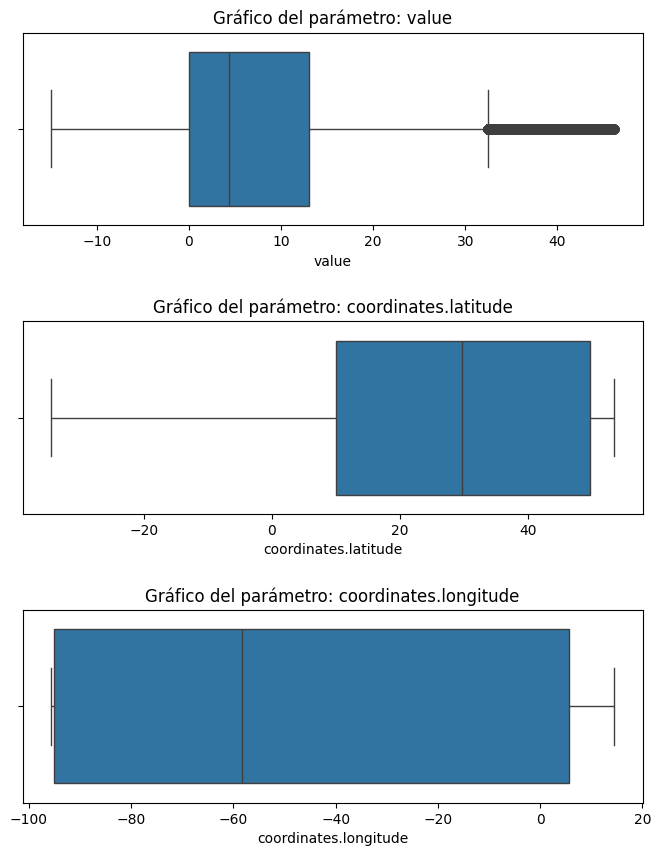

In [383]:
#revision de outliers en variables numericas
cols_num = ['value', 'coordinates.latitude', 'coordinates.longitude']

# Define la estructura del gráfico
fig, ax = plt.subplots(nrows = len(cols_num), ncols = 1, figsize = (8,10))
fig.subplots_adjust(hspace = 0.5) # Espacio entre gráficos

for i, col in enumerate(cols_num):
    sns.boxplot(x = col, data = datos, ax = ax[i]) # información para crear el gráfico
    ax[i].set_title(f'Gráfico del parámetro: {col}') # Nombre del gráfico

plt.show() # Muestra el gráfico

La siguiente porción de código se utiliza para identificar outliers en las columnas de tipo categoría. Esto con el fin de detectar, por ejemplo: mayúsculas, minúscualas, tildes dentro de las mismas categorías. Además, se grafican los parámetros de categorías con el fin de identicar si hay algún dato que necesita ser unificado, por nombre con mayúsculas o minúsculas

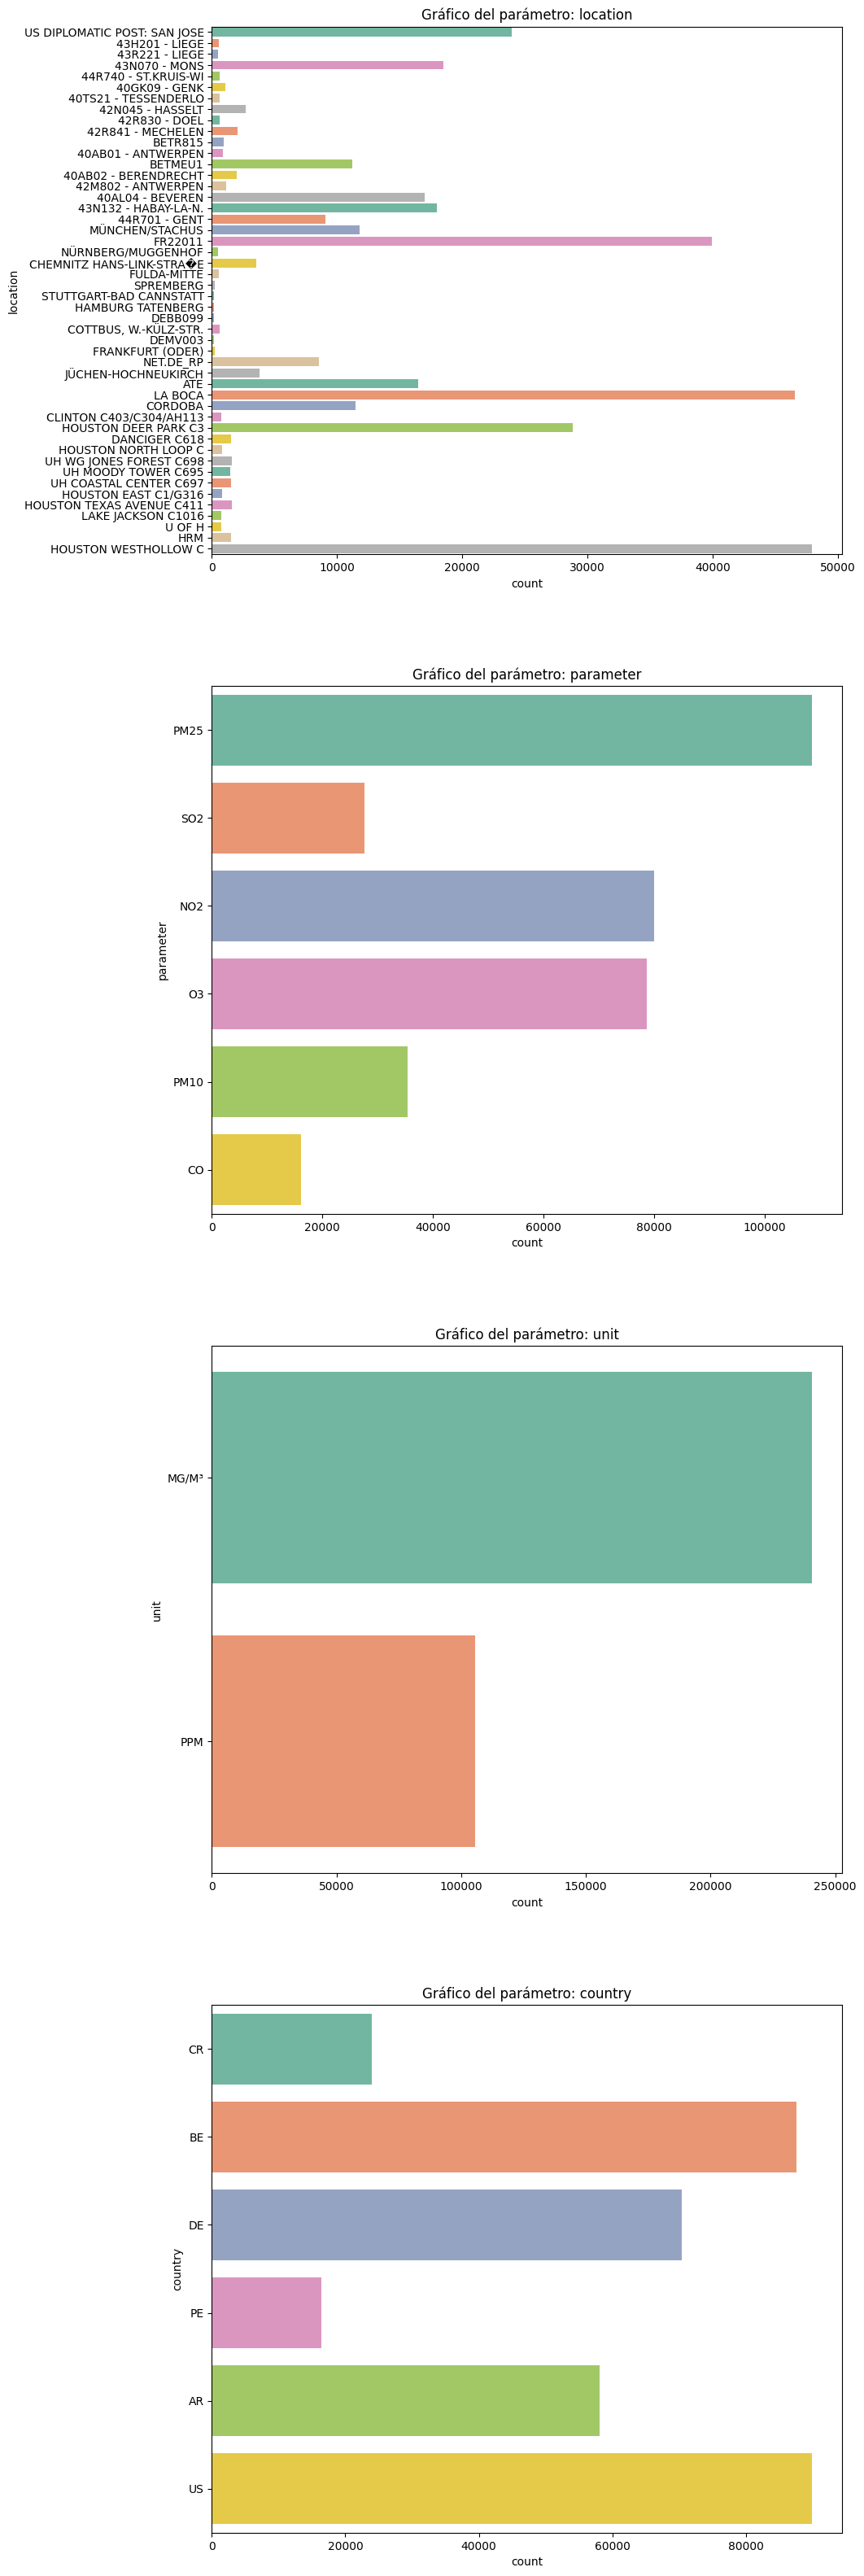

In [394]:
# Graficar los subniveles de cada variable categórica para identificar outliers
# Lista de columnas categóricas
cols_cat = ['location', 'parameter', 'unit', 'country']

# Crear figura y ejes
fig, ax = plt.subplots(nrows=len(cols_cat), ncols=1, figsize=(10, 10 * len(cols_cat)))
fig.subplots_adjust(hspace=0.25)  # Ajustar espacio entre subplots

# Iterar por cada columna categórica
for i, col in enumerate(cols_cat):
    sns.countplot(y=col, data=datos, ax=ax[i], hue=col, palette='Set2')
    ax[i].set_title(f'Gráfico del parámetro: {col}')

    # Usar plt.xticks() para rotar etiquetas sin problemas de locators
    ax[i].tick_params(axis='y', rotation=0)

# Mostrar el gráfico
plt.show()

Luego de evaluar errores tipográficos en variables categóricas no se detectaron valores atípicos, en la data. Aunque se implementó un estandar de utilizar todos los datos en mayúsculas de los datos, con el fin de graficar con mayor facilidad

In [ ]:
# Se aplica upper para que todos los valores tengan un estandar
datos['location'] = datos['location'].str.upper()
datos['parameter'] = datos['parameter'].str.upper()
datos['unit'] = datos['unit'].str.upper()
datos['country'] = datos['country'].str.upper()

datos.head()

## Análisis EDA luego de limpieza

En la limpieza y transformación de datos se fueron realizando ciertos pasos los cuales se implementaron pensando en el análisis EDA. Dado que al ir haciendo la limpieza se fueron analizando los datos de forma sistemática y esto ayudó a generar el propio análisis. A continuación se presenta de forma seccionada un resumen para Explorar, Resumir y Visualizar los datos que se están tratando con el fin de Comprender estructura, detectar patrones, detectar outliers y formular hipótesis

### Entender la estructura de los datos

### Distribución de las variables

### Detección de valores atípicos (outliers)

### Detección de valores faltantes

### Relación entre variables

### Supuestos encontrados

## Comparativa y Visualización de datos

In [ ]:
import seaborn as sns


# Convertir la columna de fechas en formato datetime
datos['date.utc'] = pd.to_datetime(datos['date.utc'])#ya se hizo esa transformación


# Agrupa los datos por país, ciudad, y parámetro
datos_agrupados = datos.groupby(['country', 'location', 'parameter', datos['date.utc'].dt.date]).mean().reset_index()


NameError: name 'pd' is not defined

###Análisis de tendencia###

In [ ]:
# Filtrar los datos de un parámetro "pm25"
parameter = 'pm25'
datos_filtrados = datos_agrupados[datos_agrupados['parameter'] == parameter]

# Crea una gráfica de línea para cada país
plt.figure(figsize=(12, 6))
sns.lineplot(x='date.utc', y='value', hue='country', data=datos_filtrados)
plt.title(f'Tendencia de {parameter} en diferentes países')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend(title='País')
plt.show()

NameError: name 'datos_agrupados' is not defined

###Comparación entre países y ciudades###

In [ ]:
# Filtrar para un parámetro "pm25" y compara entre países
datos_comparacion = datos_agrupados[datos_agrupados['parameter'] == 'pm25']

# Comparación de la media del parámetro por país
datos_comparacion_media = datos_comparacion.groupby('country')['value'].mean().reset_index()

# Barplot de comparación entre países
plt.figure(figsize=(10, 6))
sns.barplot(x='country', y='value', data=datos_comparacion_media)
plt.title('Comparación de la media de PM2.5 por país')
plt.ylabel('PM2.5')
plt.show()

## Conclusiones

# Referencias

https://docs.openaq.org/docs/introduction

https://www.kaggle.com/code/rcurioso/limpeza-datos-python-pandas

https://medium.com/nowports-tech/guia-limpiar-datos-con-pandas-3dc634c47e11

https://pypi.org/project/requests/2.16.0/

https://docs.python.org/3/library/urllib.parse.html